---
Optimization in Julia: Rocket soft landing
---

**Adapted from**: 

https://medium.com/analytics-vidhya/dynamic-optimization-in-python-rocket-soft-landing-a5a68eaf3b94

In [1]:
import Interpolations
import JuMP
using Ipopt
using Plots: plot, grid

In [2]:
# Global variables
const g = 9.81                          # m/s**2

# Rocket dimensions
const length = 50                       # m
const width = 9                         # m

# Rocket weight
const m_fuel = 1000000/5                # kg (liquid methane)
const m_dry = 120000                    # kg (rocket body + payload)
const m_total = m_dry + m_fuel

# Raptor v1 engine characteristics (only 3 engines have been seen working so far)
const v_exhaust = 3*3280           # m/s exhaust velocity at sea level. 3 sea level + 3 vacuum engines
const u_max = 3*2300000/v_exhaust  # 701 kg/s. One Raptor thrust is 2.3 MN

# # Inertia for a uniform density rod 
# I = (1/12) * m_total * length^2

# Torque from engines thrust vestoring 
const max_deflection = deg2rad(20)      # thrust vectoring +-20°
const min_deflection = -max_deflection
const max_torque = u_max * v_exhaust * length/2 * sin(max_deflection)
const min_torque = -u_max *v_exhaust * length/2 * sin(max_deflection)

# Initial conditions
const x_initial = -600                  # [m] entry x coordinate
const vx_initial = -50                  # [m/s] entry horizontal speed
const y_initial = 5000                  # [m] entry altitude
const vy_initial = 0                    # [m/s] entry vertical speed
const theta_initial = deg2rad(-90)      # [radian]  - rockets starts free falling in belly down position 
const vtheta_initial = 0                # [radian/s]
const m_initial = m_total               # [kg]
const u_initial = 0                     # [kg/s] - engines off
const thrust_angle_initial = 0          # [radian]
const torque_initial = 0                # [N*m]
const time_step = 1                     # [s] 

# Final conditions
const x_landing = 0                     # [m] landing x coordinate. Bottom middle of sim box 
const vx_landing = 0                    # [m/s] landing altitude
const y_landing = 0                     # [m] landing altitude
const vy_landing = 0                    # [m/s] landing speed
const theta_landing = 0                 # [radian] - land upright 
const vtheta_landing = 0                # [radian/s]
# const m_landing = 0.5*m_total           # [kg]
# const u_landing = 0                     # [kg/s]
const thrust_angle_landing = 0          # [radian]
const torque_landing = 0                # [N*m]

# Number of mesh points (knots) to be used
const n = 100

# Integration scheme to be used for the dynamics
const integration_rule = "rectangular";

In [3]:
user_options_ipopt = (
    "mu_strategy" => "monotone",
    "linear_solver" => "ma27",  # For the best results, it is advised to experiment different linear solvers.
                                # If Ipopt is not compiled with MA27/MA57, it may fallback to 'MUMPS'.
                                # In general, the linear solver MA27 is much faster than MUMPS.
    "max_iter" => 4000,
    "max_cpu_time" => 180.,     # sec
    "print_level" => 4          # 5 default
)

# Create JuMP model, using Ipopt as the solver
model = JuMP.Model(JuMP.optimizer_with_attributes(Ipopt.Optimizer, user_options_ipopt...));

In [4]:
@JuMP.variables(model, begin
                -1500 <= x[1:n] <= 1500             # horizontal coordinates [m]
                  -80 <= vx[1:n] <= 80              # horizontal speed [m/s] (speed of sound 343 m/s)
                    0 <= y[1:n] <= y_initial        # altitude [m]
                  -80 <= vy[1:n] <= 0               # vertical speed [m/s]
                -2*pi <= theta[1:n] <= 2*pi         # angle of rotation along rocket centre [radian]
         -deg2rad(45) <= vtheta[1:n] <= deg2rad(45) # angular speed [radian/s]
                m_dry <= m[1:n] <= m_total          # mass (dry + fuel) [kg]
                    0 <= u[1:n] <= u_max            # engine mass flow [kg/s]
       min_deflection <= thrust_angle[1:n] <= max_deflection # thrust vectoring angle [radian]
                         dt[1:n] == time_step       # time step [sec]
end)

# Fix initial conditions
JuMP.fix(x[1], x_initial; force=true)
JuMP.fix(vx[1], vx_initial; force=true)
JuMP.fix(y[1], y_initial; force=true)
JuMP.fix(vy[1], vy_initial; force=true)
JuMP.fix(theta[1], theta_initial; force=true)
JuMP.fix(vtheta[1], vtheta_initial; force=true)
JuMP.fix(m[1], m_initial; force=true)
JuMP.fix(u[1], u_initial; force=true)
JuMP.fix(thrust_angle[1], thrust_angle_initial; force=true)

# Fix final conditions
JuMP.fix(x[n], x_landing; force=true)
JuMP.fix(vx[n], vx_landing; force=true)
JuMP.fix(y[n], y_landing; force=true)
JuMP.fix(vy[n], vy_landing; force=true)
JuMP.fix(theta[n], theta_landing; force=true)
JuMP.fix(vtheta[n], vtheta_landing; force=true)
# JuMP.fix(m[n], m_landing; force=true)
# JuMP.fix(u[n], u_landing; force=true)
JuMP.fix(thrust_angle[n], thrust_angle_landing; force=true)

In [5]:
# Initial guess: linear interpolation between boundary conditions
initial = [x_initial, vx_initial, y_initial, vy_initial, theta_initial, vtheta_initial, 
                m_initial, u_initial, thrust_angle_initial, time_step]
final = [x_landing, vx_landing, y_landing, vy_landing, theta_landing, vtheta_landing, 
                m_initial, u_initial, thrust_angle_landing, time_step]

interp_linear = Interpolations.LinearInterpolation([1, n], [initial, final])
initial_guess = Interpolations.mapreduce(transpose, vcat, interp_linear.(1:n))
print(size(initial_guess))

JuMP.set_start_value.(JuMP.all_variables(model), vec(initial_guess));

(100, 10)

In [6]:
# Torque from engine thrust vectoring 
@JuMP.NLexpression(model, torque[j = 1:n], -0.5*length*v_exhaust*u[j]*sin(thrust_angle[j]))
@JuMP.NLexpression(model, atheta[j = 1:n], torque[j]/(m[j]*length^2 / 12))     # = Torque / Moment of Inertia

# Rocket acceleration from engine thrust and gravity
@JuMP.NLexpression(model, dvx[j = 1:n], (v_exhaust*u[j]*sin(thrust_angle[j] + theta[j])) / m[j])
@JuMP.NLexpression(model, dvy[j = 1:n], (-m[j]*g + v_exhaust*u[j]*cos(thrust_angle[j] + theta[j])) / m[j])

# Fuel used
@JuMP.expression(model, fuel, sum(u))

# Objective function
@JuMP.expression(model, OF, sum(1*vx.^2 + 1*u.^2 + 1*x.^2))

# System dynamics as a differential-algebraic system of equations
for j in 2:n
    i = j - 1

    if integration_rule == "rectangular"
        # Rectangular integration
        @JuMP.NLconstraint(model, x[j] == x[i] + dt[i] * vx[i])                # vx = dx/dt
        @JuMP.NLconstraint(model, vx[j] == vx[i] + dt[i] * dvx[i])             # ax = dvx/dt
        @JuMP.NLconstraint(model, y[j] == y[i] + dt[i] * vy[i])                # vy = dy/dt
        @JuMP.NLconstraint(model, vy[j] == vy[i] + dt[i] * dvy[i])             # ay = dvy/dt
        @JuMP.NLconstraint(model, theta[j] == theta[i] + dt[i] * vtheta[i])    # ang_speed = dtheta/dt
        @JuMP.NLconstraint(model, vtheta[j] == vtheta[i] + dt[i] * atheta[i])  # ang_acceleration = d(ang_speed)/dt
        @JuMP.NLconstraint(model, m[j] == m[i] - dt[i] * u[i])                 # dm/dt = -u
    elseif integration_rule == "trapezoidal"
        # Trapezoidal integration
        @JuMP.NLconstraint(model, x[j] == x[i] + 0.5 * dt[i] * (dx[j] + dx[i]))
        @JuMP.NLconstraint(model, vx[j] == vx[i] + 0.5 * dt[i] * (dvx[j] + dvx[i]))
        @JuMP.NLconstraint(model, y[j] == y[i] + 0.5 * dt[i] * (dy[j] + dy[i]))
        @JuMP.NLconstraint(model, vy[j] == vy[i] + 0.5 * dt[i] * (dvy[j] + dvy[i]))
        @JuMP.NLconstraint(model, theta[j] == theta[i] + 0.5 * dt[i] * (vtheta[j] + vtheta[i]))
        @JuMP.NLconstraint(model, vtheta[j] == vtheta[i] + 0.5 * dt[i] * (atheta[j] + atheta[i]))
        @JuMP.NLconstraint(model, m[j] == m[i] - 0.5 * dt[i] * (u[j] + u[i]))
    else
        @JuMP.error "Unexpected integration rule '$(integration_rule)'"
    end
end

In [7]:
# Objective: Minimize fuel expenditure + horizontal movements
@JuMP.objective(model, Min, OF)

# Solve for the control and state
@time status = JuMP.optimize!(model)

println("Objective function value = ", round(JuMP.objective_value(model), digits = 4))
println("Fuel used = ", round(JuMP.value(fuel), digits = 4))


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Total number of variables............................:      884
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      884
                     variables with only upper bounds:        0
Total number of equality constraints.................:      693
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

In iteration 306, 1 Slack too small,

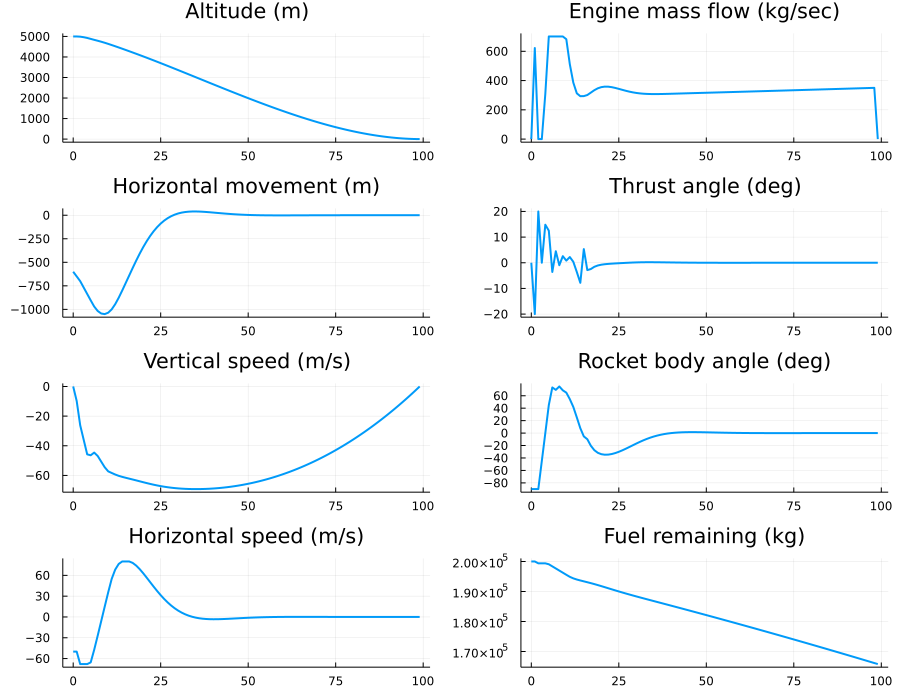

In [8]:
ts = cumsum([0; JuMP.value.(dt)])[1:end-1]

plt_altitude = plot(ts, JuMP.value.(y), legend = nothing, title = "Altitude (m)")
plt_x = plot(ts, JuMP.value.(x), legend = nothing, title = "Horizontal movement (m)")
plt_vy = plot(ts, JuMP.value.(vy), legend = nothing, title = "Vertical speed (m/s)")
plt_vx = plot(ts, JuMP.value.(vx), legend = nothing, title = "Horizontal speed (m/s)")
plt_thrust = plot(ts, JuMP.value.(u), legend = nothing, title = "Engine mass flow (kg/sec)")
plt_thrust_angle = plot(ts, rad2deg.(JuMP.value.(thrust_angle)), legend = nothing, title = "Thrust angle (deg)")
plt_fuel = plot(ts, JuMP.value.(m) .- m_dry, legend = nothing, title = "Fuel remaining (kg)")
plt_theta = plot(ts, rad2deg.(JuMP.value.(theta)), legend = nothing, title = "Rocket body angle (deg)")

plt = plot(plt_altitude, plt_thrust, plt_x, plt_thrust_angle, plt_vy, plt_theta, plt_vx, plt_fuel, 
    layout=grid(4, 2), linewidth=2, size=(900, 700))

## Landing animation

In [9]:
import PyCall
state_vector = hcat(JuMP.value.(x), JuMP.value.(vx), JuMP.value.(y), JuMP.value.(vy), JuMP.value.(theta), JuMP.value.(vtheta))
control_vector = hcat(v_exhaust*JuMP.value.(u), JuMP.value.(thrust_angle));

In [10]:
PyCall.py"""
def save_arr(x, name):
    import numpy as np
    np.save(name, x)
"""
save_arr = PyCall.py"save_arr"

save_arr(state_vector, "state_vector.npy")
save_arr(control_vector, "control_vector.npy")

In [11]:
# Landing visualization can be generated in animation_rocket_soft_landing python notebook